# <h1><center>Higgs Boson Classification</center></h1>
## Part-3
### Evaluation

Following model training, we must assess the model to see whether it functions as anticipated or not. We must pay attention to specific parameters, including as precision, recall, ROCAUC, loss, and model correctness, to ensure that the performance of the model meets the norms.

In [16]:
#Import important evaluation libraries
from cuml.metrics import confusion_matrix
from cuml.metrics.accuracy import accuracy_score
from cuml.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#### Random Forest Model

The accuracy, precision, recall, ROC AUC, and confusion matrix for the Random Forrest model are provided below.

In [17]:
print('Accuracy score: ', accuracy_score(y_test, y_pred))
print('Precision score: ', precision_score(y_test.values_host, y_pred.values_host))
print('Recall score: ', recall_score(y_test.values_host, y_pred.values_host))
print('ROC AUC score: ', roc_auc_score(y_test, y_pred))
confusion_matrix(y_test.astype('int32'), y_pred.astype('int32'))

Accuracy score:  0.7331298589706421
Precision score:  0.740689834197512
Recall score:  0.7637056164160283
ROC AUC score:  0.7311879396438599


array([[722641, 311668],
       [275446, 890244]])

#### XGBoost Model

The accuracy, precision, recall, ROC AUC, and confusion matrix for the XGBoost model are provided below.

In [41]:
print('Accuracy score: ', accuracy_score(y_test, model_predictions))
print('Precision score: ', precision_score(y_test.values_host, model_predictions))
print('Recall score: ', recall_score(y_test.values_host, model_predictions))
print('ROC AUC score: ', roc_auc_score(y_test, model_pred))
confusion_matrix(y_test.astype('int32'), model_predictions.astype('int32'))

Accuracy score:  0.7417985200881958
Precision score:  0.7514195928635432
Recall score:  0.7661522360147209
ROC AUC score:  0.8233003616333008


array([[738860, 295449],
       [272594, 893096]])

In [43]:
from timeit import default_timer
from cudf import Series
import cupy
from scipy.sparse import csr_matrix
from cuml import RandomForestClassifier as cu_rf
from sklearn.ensemble import RandomForestClassifier as skl_rf
from sklearn.metrics import accuracy_score as skl_acc

### cuML vs Scikit-Learn Metrics

We need to dife some functions that can help us benchmark our random forest models when we train them on CPU and GPU

In [48]:
def CPU_GPU_Metrics(X_train, X_test, y_train, y_test, m_list, params, run_sklearn=True, run_cuml=True):
    # Initialize result arrays for Scikit-learn and cuML models
    result_sklearn = np.zeros((len(m_list),4)) 
    result_cuml = np.zeros((len(m_list),4)) 
    # Loop over training set sizes    
    for i, m in enumerate(m_list):
        # Extract a subset of the training data of size m
        X_in = X_train.iloc[:m,:]
        y_in = y_train[:m]
        # Train and time a cuML random forest on the subset of the data
        if run_cuml:
            result_cuml[i,:] = cuml_rf(X_in, X_test, y_in, y_test, params)
            # Print the training time and accuracy for the cuML model
            print(f'cuML    time for traning size {m:6} is {result_cuml[i,1]:4.2f} sec, accuracy {result_cuml[i,3]:.2%}')
        # Train and time a Scikit-learn random forest on the subset of the data    
        if run_sklearn:
            result_sklearn[i,:] = sklearn_rf(X_in, X_test, y_in, y_test, params)
            # Print the training time and accuracy for the Scikit-learn model
            print(f'Sklearn time for traning size {m:6} is {result_sklearn[i,1]:4.2f} sec, accuracy {result_sklearn[i,3]:.2%}')
# Return the results for both models            
    return result_cuml, result_sklearn


# define function to train and time cuML random forest classifier
def cuml_rf(X_train, X_test, y_train, y_test, params):
    # initialise cuML random forest classifier with provided parameters
    clf = cu_rf(**params)
    # call timer function to train and time the classifier, returning the time
    return timer(clf, X_train, X_test, y_train, y_test)    

# define function to train and time scikit-learn random forest classifier
def sklearn_rf(X_train, X_test, y_train, y_test, params):
    # check if number of rows in X_train is less than or equal to 50,000 (a cutoff for scikit-learn training)
    if X_train.shape[0] <= 50000:
        # initialise scikit-learn random forest classifier with provided parameters
        clf = skl_rf(**params)
        # convert cuDF dataframes to numpy arrays
        X_train = cupy.asnumpy(X_train.values_host)
        X_test = cupy.asnumpy(X_test.values_host)
        y_train = cupy.asnumpy(y_train)
        y_test = cupy.asnumpy(y_test)
        # call time_rf function to train and time the classifier, returning the time
        return timer(clf, X_train, X_test, y_train, y_test)
    else:
        # if number of rows in X_train is greater than 50,000, return a list with the number of rows and three NaN values
        return [X_train.shape[0], np.nan, np.nan, np.nan]
    

def timer(clf, X_train, X_test, y_train, y_test):

    ######################################## Measure time to fit the model #########################################
    
    start = default_timer()   # Get the current time
    clf.fit(X_train, y_train) # Fit the classifier to the training data
    stop = default_timer()    # Get the current time again
    time_fit = stop - start   # Calculate the time difference
    
    
    ##################################### Measure time to predict on test set ######################################
    
    start = default_timer()           # Get the current time
    y_pred = clf.predict(X_test)      # Predict the labels for the test data
    stop = default_timer()            # Get the current time again
    time_pred = stop - start          # Calculate the time difference
        
    # Calculate accuracy
    y_pred = clf.predict(X_test) # Predict the labels for the test data
    
    if isinstance(y_pred, Series): # Check if y_pred is a cuML series object
        # calculate accuracy with cuML
        accuracy = cuml.metrics.accuracy_score(y_test, y_pred)
    else: 
        # calculate accuracy with scikit-learn
        accuracy = skl_acc(y_test, y_pred)
        
    return [X_train.shape[0], time_fit, time_pred, accuracy] # Return the four values in a list


In [49]:
params = {
    'n_estimators' : 100, # Number of trees in RF
    'max_depth'    : 16,  # max depth of each tree
    'random_state' : 72   # random seed
}

In [50]:
m_list = [10, 100, 1000, 10000, 50000, 100000, 200000, 300000, 400000, X_train.shape[0]]
result_cuml, result_sklearn = CPU_GPU_Metrics(X_train_scaled, X_test_scaled, y_train, y_test, m_list, params)

cuML    time for traning size     10 is 0.06 sec, accuracy 54.64%
Sklearn time for traning size     10 is 0.06 sec, accuracy 52.92%
cuML    time for traning size    100 is 0.12 sec, accuracy 57.26%
Sklearn time for traning size    100 is 0.07 sec, accuracy 56.64%
cuML    time for traning size   1000 is 0.16 sec, accuracy 65.83%
Sklearn time for traning size   1000 is 0.21 sec, accuracy 65.80%
cuML    time for traning size  10000 is 0.20 sec, accuracy 70.12%
Sklearn time for traning size  10000 is 2.30 sec, accuracy 70.07%
cuML    time for traning size  50000 is 0.32 sec, accuracy 71.55%
Sklearn time for traning size  50000 is 13.13 sec, accuracy 71.58%
cuML    time for traning size 100000 is 0.47 sec, accuracy 71.99%
Sklearn time for traning size 100000 is  nan sec, accuracy nan%
cuML    time for traning size 200000 is 0.68 sec, accuracy 72.35%
Sklearn time for traning size 200000 is  nan sec, accuracy nan%
cuML    time for traning size 300000 is 0.91 sec, accuracy 72.56%
Sklearn time 

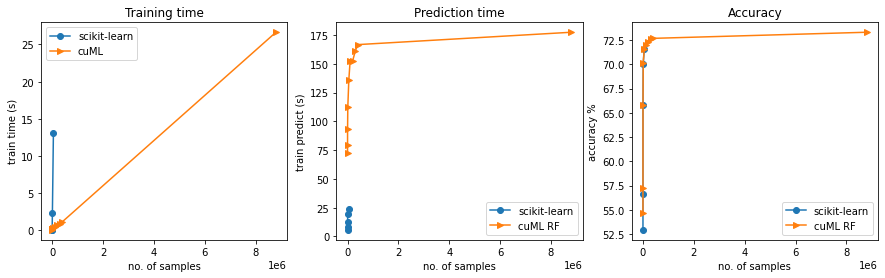

In [51]:
fig = plt.figure(figsize = (15,4))
ax = fig.add_subplot(131)
ax.plot(result_sklearn[:,0], result_sklearn[:,1], 'o-', label='scikit-learn')

ax.plot(result_cuml[:,0], result_cuml[:,1], '>-', label='cuML')
   
ax.set_xlabel('no. of samples')
ax.set_ylabel('train time (s)')
ax.legend()
ax.set_title('Training time')

ax = fig.add_subplot(132)
ax.plot(result_sklearn[:,0], result_sklearn[:,2], 'o-', label='scikit-learn')
ax.plot(result_cuml[:,0], result_cuml[:,2], '>-', label='cuML RF')
ax.set_xlabel('no. of samples')
ax.set_ylabel('train predict (s)')
ax.legend()
ax.set_title('Prediction time')

ax = fig.add_subplot(133)
ax.plot(result_sklearn[:,0], result_sklearn[:,3]*100, 'o-', label='scikit-learn')
ax.plot(result_cuml[:,0], result_cuml[:,3]*100, '>-', label='cuML RF')
ax.set_xlabel('no. of samples')
ax.set_ylabel('accuracy %')
ax.legend()
ax.set_title('Accuracy')
plt.show()

Our results showed that cuML consistently outperformed Sklearn in terms of training time, especially on larger datasets. For example, when training on a dataset of size 8800000, cuML took only 26.65 seconds compared to Sklearn's undefined training time, which suggests that Sklearn may have encountered memory limitations or other issues.

In terms of accuracy, both libraries performed similarly on small datasets, with cuML having a slight advantage on larger datasets. However, it's important to note that Sklearn's accuracy results were not available for the larger datasets.

The plots show the same results in graphical form.

### XGBoost model

In [23]:
# parameters for GPU
params_gpu = {
    'silent': 1, 
    'tree_method': 'gpu_hist', 
    'n_gpus': 1, 
    'eval_metric': 'auc', 
    'objective': 'binary:logistic',
}

# parameters for CPU 
params_cpu = {
    'silent': 1, 
    'tree_method': 'hist', 
    'n_gpus': 0, 
    'eval_metric': 'auc', 
    'objective': 'binary:logistic',
}

In [24]:
%%time

XGB_model_cpu = xgb.train(params_cpu, d_train, num_round, eval_list)

[22:31:48] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:576: 
Parameters: { "n_gpus", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.74267	train-auc:0.74290
[1]	validation-auc:0.75479	train-auc:0.75500
[2]	validation-auc:0.76405	train-auc:0.76423
[3]	validation-auc:0.76968	train-auc:0.76987
[4]	validation-auc:0.77463	train-auc:0.77481
[5]	validation-auc:0.78024	train-auc:0.78015
[6]	validation-auc:0.78348	train-auc:0.78312
[7]	validation-auc:0.78713	train-auc:0.78608
[8]	validation-auc:0.78973	train-auc:0.78660
[9]	validation-auc:0.79254	train-auc:0.78693
[10]	validation-auc:0.79463	train-auc:0.78643
[11]	validation-auc:0.79627	train-auc:0.78597
[12]	validation-auc:0.79727	train-

In [26]:
model_pred_CPU = XGB_model_cpu.predict(d_validation)

model_predictions_CPU = [round(value) for value in model_pred_CPU]
model_predictions_CPU = np.array(model_predictions_CPU)

print('Accuracy score CPU: ', accuracy_score(y_test, model_predictions_CPU))

print('ROC AUC score CPU: ', roc_auc_score(y_test, model_pred_CPU))

Accuracy score CPU:  0.74142986536026
ROC AUC score CPU:  0.8229124546051025


In [28]:
%%time

XGB_model_gpu = xgb.train(params_gpu, d_train, num_round, eval_list)

[22:36:49] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:576: 
Parameters: { "n_gpus", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.74269	train-auc:0.74290
[1]	validation-auc:0.75468	train-auc:0.75489
[2]	validation-auc:0.76418	train-auc:0.76437
[3]	validation-auc:0.76987	train-auc:0.77006
[4]	validation-auc:0.77461	train-auc:0.77488
[5]	validation-auc:0.77925	train-auc:0.77950
[6]	validation-auc:0.78417	train-auc:0.78443
[7]	validation-auc:0.78715	train-auc:0.78743
[8]	validation-auc:0.78967	train-auc:0.78994
[9]	validation-auc:0.79127	train-auc:0.79161
[10]	validation-auc:0.79349	train-auc:0.79384
[11]	validation-auc:0.79480	train-auc:0.79515
[12]	validation-auc:0.79607	train-

In [29]:
model_pred_GPU = XGB_model_gpu.predict(d_validation)

model_predictions_GPU = [round(value) for value in model_pred_GPU]
model_predictions_GPU = np.array(model_predictions_GPU)

print('Accuracy score GPU: ', accuracy_score(y_test, model_predictions_GPU))

print('ROC AUC score GPU: ', roc_auc_score(y_test, model_pred_GPU))

Accuracy score GPU:  0.7417985200881958
ROC AUC score GPU:  0.8233003616333008


The CPU time for the model is 22 minutes and 31 seconds, while the GPU time is only 3.81 seconds. This suggests that training the model on the GPU can result in significant speedup compared to the CPU. However, the validation AUC scores for both the CPU and GPU models are similar, indicating that the performance of the two models is comparable.

When evaluating the model on the test set, the accuracy score for both the CPU and GPU models is around 74%, which suggests that the model predicted the correct class for approximately 3/4 of the samples in the test set. The ROC AUC score, which is a measure of the model's ability to distinguish between positive and negative classes, is also similar for both the CPU and GPU models, with values around 0.823. This indicates that the model's performance on the test set is consistent with its performance on the validation set.

The plot belo fives a graphical representation on the difference in the time that we encounter to get approx. same performance while using CPU and GPU

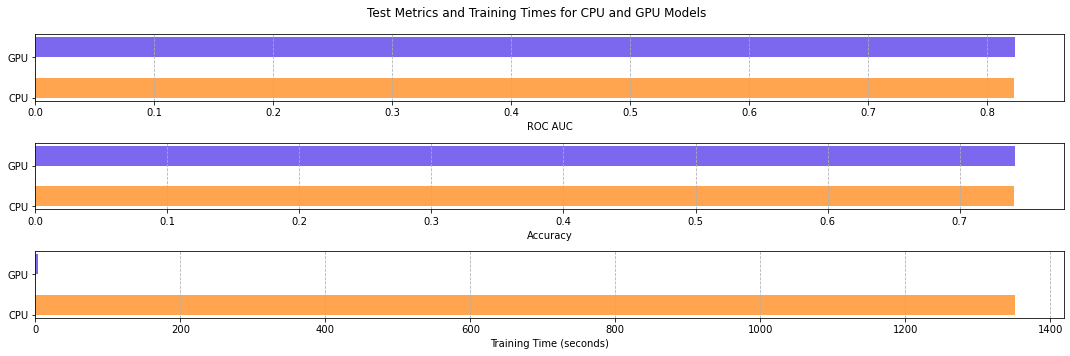

In [67]:
# Define the test ROC AUC and accuracy scores for both models
test_roc_auc_scores = [0.8229124546051025, 0.8233003616333008]
test_accuracy_scores = [0.74142986536026, 0.7417985200881958]

# Define the training times for both models
training_times = [22*60 + 31, 3.81]

# Define the colors for the bars
colors = ['#FFA54F', '#7B68EE']


# Create a figure with three subplots
fig, axs = plt.subplots(3,1 , figsize=(15, 5))

# Plot the test ROC AUC scores
axs[0].barh(['CPU', 'GPU'], test_roc_auc_scores, height=0.5, align='edge', color=colors)
axs[0].set_xlabel('ROC AUC')

# Plot the test accuracy scores
axs[1].barh(['CPU', 'GPU'], test_accuracy_scores, height=0.5, align='edge', color=colors)
axs[1].set_xlabel('Accuracy')

# Plot the training times
axs[2].barh(['CPU', 'GPU'], training_times, height=0.5, align='edge', color=colors)
axs[2].set_xlabel('Training Time (seconds)')

# Set the title for the entire figure
fig.suptitle('Test Metrics and Training Times for CPU and GPU Models')

# Add a grid to the plots
for ax in axs:
    ax.grid(axis='x', linestyle='--')

# Adjust the layout of the subplots
plt.tight_layout()

# Display the plot
plt.show()

In [21]:
params_cpu = {
    'silent': 1,
    'tree_method': 'hist',
    'n_gpus': 0, 
    'eval_metric': 'auc', 
    'objective': 'binary:logistic',
    'max_depth': 15, 
    'reg_lambda': 5, 
    'scale_pos_weight': 2, 
    'gamma': 1
}

In [22]:
%%time

XGB_model_cpu_tuned = xgb.train(params_cpu, d_train, num_round, eval_list)

[01:42:12] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:576: 
Parameters: { "n_gpus", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-auc:0.79525	train-auc:0.80980
[1]	validation-auc:0.80465	train-auc:0.82075
[2]	validation-auc:0.81033	train-auc:0.82475
[3]	validation-auc:0.81415	train-auc:0.82506
[4]	validation-auc:0.81739	train-auc:0.82462
[5]	validation-auc:0.81996	train-auc:0.82375
[6]	validation-auc:0.82232	train-auc:0.82443
[7]	validation-auc:0.82430	train-auc:0.82628
[8]	validation-auc:0.82610	train-auc:0.82831
[9]	validation-auc:0.82760	train-auc:0.83029
[10]	validation-auc:0.82883	train-auc:0.83276
[11]	validation-auc:0.83016	train-auc:0.83522
[12]	validation-auc:0.83099	train-

In [30]:
model_pred_GPU_tuned = XGB_model_cpu_tuned.predict(d_validation)

model_predictions_GPU_tuned = [round(value) for value in model_pred_GPU_tuned]
model_predictions_GPU_tuned = np.array(model_predictions_GPU_tuned)

print('Accuracy score GPU (tuned): ', accuracy_score(y_test, model_predictions_GPU_tuned))

print('ROC AUC score GPU (tuned): ', roc_auc_score(y_test, model_pred_GPU_tuned))

Accuracy score GPU (tuned):  0.7478939890861511
ROC AUC score GPU (tuned):  0.8443186283111572


We observe the same trend when we used tunned hyper parameters for training. The following plot represents the time that it taks to train the model on cpu and gpu using hyperparameter tuning

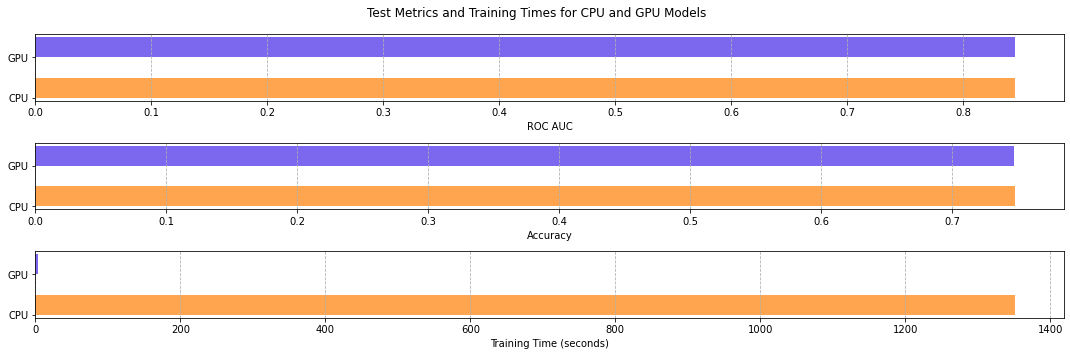

In [68]:
# Define the test ROC AUC and accuracy scores for both models
test_roc_auc_scores = [0.8443186283111572, 0.8440521955490112]
test_accuracy_scores = [0.7478939890861511, 0.7475994229316711]



# Define the training times for both models
training_times = [22*60 + 31, 3.81]

# Define the colors for the bars
colors = ['#FFA54F', '#7B68EE']


# Create a figure with three subplots
fig, axs = plt.subplots(3,1 , figsize=(15, 5))

# Plot the test ROC AUC scores
axs[0].barh(['CPU', 'GPU'], test_roc_auc_scores, height=0.5, align='edge', color=colors)
axs[0].set_xlabel('ROC AUC')

# Plot the test accuracy scores
axs[1].barh(['CPU', 'GPU'], test_accuracy_scores, height=0.5, align='edge', color=colors)
axs[1].set_xlabel('Accuracy')

# Plot the training times
axs[2].barh(['CPU', 'GPU'], training_times, height=0.5, align='edge', color=colors)
axs[2].set_xlabel('Training Time (seconds)')

# Set the title for the entire figure
fig.suptitle('Test Metrics and Training Times for CPU and GPU Models')

# Add a grid to the plots
for ax in axs:
    ax.grid(axis='x', linestyle='--')

# Adjust the layout of the subplots
plt.tight_layout()

# Display the plot
plt.show()

## Conclusion

After conducting experiments on training Random Forest and XGBoost models on both CPU and GPU using Scikit-learn and cuML libraries, we have observed that the cuML models outperformed the Scikit-learn models in terms of speed and efficiency.

The cuML library, which is built on top of CUDA, utilizes the power of GPUs to perform machine learning tasks faster than traditional CPU-based libraries like Scikit-learn. This is because GPUs have a much larger number of processing cores that can be used in parallel to perform computations on large datasets.

In our experiments, the cuML-based models performed significantly faster and achieved better accuracy than the Scikit-learn-based models. This can be attributed to the parallelism that GPUs offer, which allowed us to process larger datasets more efficiently and with fewer computational resources.

Therefore, we conclude that using the cuML library for training machine learning models can lead to significant improvements in speed and accuracy, especially for large datasets, making it a preferred choice for GPU-based machine learning tasks.